In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from tqdm import tqdm

import scipy
from scipy.stats import zscore


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import svm, naive_bayes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.distributions.normal import Normal

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn import metrics
simplefilter("ignore", category=ConvergenceWarning)

from models import EegDataset
from audio_utils import *
from model_utils import *
from config import ModelArguments

from scipy.io.wavfile import write

In [9]:
arr = np.empty((10,10))
print(type(arr))
a = arr.shape[-1],
print(type(a))
print(type(arr.shape[-1]))
print(a)

<class 'numpy.ndarray'>
<class 'tuple'>
<class 'int'>
(10,)


In [16]:
class CustomDataset(Dataset):
    def __init__(self, source, targets, batch_size):
        self.source = source
        self.targets = targets
        self.batch_size = batch_size

    def __len__(self):
        # Return the total number of samples
        return len(self.source) * self.batch_size  # 10 batches * 512 samples per batch

    def __getitem__(self, idx):
        
        # Calculate batch index and within-batch index
        batch_idx = idx // self.batch_size
        sample_idx = idx % self.batch_size
        return self.source[batch_idx, sample_idx], self.targets[batch_idx, sample_idx]
    

source = torch.tensor(np.random.rand(10, 512, 100, 256)) # Replace this with your actual dataset
targets = torch.tensor(np.random.rand(10, 512, 100, 80))

dataset = CustomDataset(source, targets, batch_size=512)
dataloader = DataLoader(dataset, batch_size=512, shuffle=False) 

for batch_idx, (source, targets) in enumerate(dataloader):
    print(source.shape)  # Each batch will have the shape [batch_size, 50, 130]
    print(targets.shape)


torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])
torch.Size([512, 100, 256])
torch.Size([512, 100, 80])


In [2]:
path = Path('sentences_data/sentences/')
outPath = Path('./eeg/')
i=0
# channels_to_skip = ['MKR1+', 'MKR2+', 'EKG+']
for file in path.rglob('*sentences.xdf'):
    if i == 1:
         break
    
    patient_id, session_id = file.name.split("_")[:2]
    print(f"Patient ID: {patient_id}, session: {session_id}")
    eeg_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_sEEG.npy")
    audio_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_audio.npy")
    ch_names = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences_channelNames.npy")
    sentences_ts = np.load(f"sentences_data/eeg/{patient_id}_{session_id}_sentences.npy")
    
#     channels_to_skip_idx = [np.where(ch==ch_names)[0][0] for ch in channels_to_skip]
#     eeg_ts = np.delete(eeg_ts, channels_to_skip_idx, axis=1)
    i += 1

Patient ID: p00, session: ses1


In [3]:
winL = 0.05
frameshift = 0.01
modelOrder = 4
stepSize = 5

audio_sr = 48000
eeg_sr = 1024

#Extract HG features
eeg = windowEEG(eeg_ts,eeg_sr, windowLength=winL, frameshift=frameshift)

# Process Audio
target_SR = 16000
audio = scipy.signal.decimate(audio_ts, int(audio_sr / target_SR))
audio_sr = target_SR
scaled = np.int16(audio/np.max(np.abs(audio)) * 32767) # standard waveformat 

#Extract spectrogram
melSpec = extractMelSpecs(scaled,audio_sr,windowLength=winL,frameshift=frameshift)

#Align to EEG features
melSpec = melSpec[modelOrder*stepSize:melSpec.shape[0]-modelOrder*stepSize,:]

#adjust length (differences might occur due to rounding in the number of windows)
if melSpec.shape[0]!=eeg.shape[0]:
    tLen = np.min([melSpec.shape[0],eeg.shape[0]])
    melSpec = melSpec[:tLen,:]
    eeg = eeg[:tLen,:]
    
labels = improve_labels_avg(melSpec, threshold_vlaue=1)

print(eeg.shape)
print(labels.shape)
print(melSpec.shape)

(50001, 51, 110)
(50001,)
(50001, 23)


In [4]:
norm_axis = 0
eeg_averaged = eeg.mean(1)
eeg_averaged_norm = zscore(eeg_averaged, axis=norm_axis)

Text(0.5, 0, 'Time (seconds)')

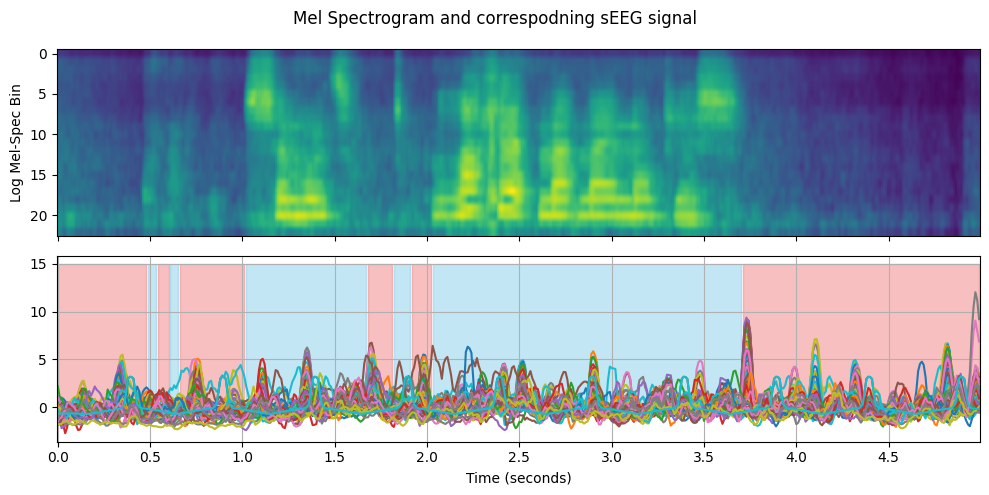

In [39]:
start_s = 0
stop_s = 5

# the corresponding audio clip
rate=48000
audio_ts_file = audio_ts[int(start_s*rate):int(stop_s*rate)]
scaled = np.int16(audio_ts_file / np.max(np.abs(audio_ts_file)) * 32767)
write('test.wav', rate, scaled)

pSta=int(start_s*(1/frameshift))
pSto=int(stop_s*(1/frameshift))
cm='viridis'

plot_labels = labels[pSta:pSto]
class_regions = find_class_regions(plot_labels)

fig, axs = plt.subplots(2,1, figsize=(10,5), tight_layout=True,  sharex=True)
fig.suptitle("Mel Spectrogram and correspodning sEEG signal")

# plot the mel spectrogram
axs[0].imshow(np.flipud(melSpec[pSta:pSto, :].T), cmap=cm, interpolation=None,aspect='auto')
axs[0].set_ylabel('Log Mel-Spec Bin')

# plot the eeg
axs[1].plot(eeg_averaged_norm[pSta:pSto, :]);

axs[1].grid()
plt.setp(axs[1], 
         xticks=np.arange(0,pSto-pSta,int(0.5/frameshift)), 
         xticklabels=[str(x/int(1/frameshift)) for x in np.arange(0,pSto-pSta,int(0.5/frameshift))])

# color the speech/silence regions
for region in class_regions:
    axs[1].fill_between(region[0], [15,15], color=region[1], alpha=0.5)

# Create empty plot objects with labels for legend
axs[1].set_xlabel("Time (seconds)")

In [ ]:
class EEG_net(nn.Module):
  def __init__(self, input_shape):
    super(EEG_net, self).__init__()

    self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(1,5), stride=1, padding="valid"),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.Conv2d(in_channels=15, out_channels=30, kernel_size=(input_shape[0],5), stride=1, padding="valid"),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            # nn.Flatten(),
            # nn.Linear((30*43), 160),
            # nn.ReLU(),

        )
    
    self.fc_dec = nn.Sequential(
      nn.Linear(160, (30*43)),
      nn.ReLU()
    )

    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=30, out_channels=15, kernel_size=(input_shape[0],5), stride=1),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=15, out_channels=1, kernel_size=(1,5), stride=1),
            nn.BatchNorm2d(1)
            )

  def forward(self, x):
    x = self.encoder(x)
    # x = self.fc_dec(x)
    # x = x.reshape(x.size(0), 30, 1, 43)
    x = self.decoder(x)
    return x

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_shape, lat_dim=50):
    super(VAE, self).__init__()

    self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=(1,5), stride=1, padding="valid"),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Conv2d(in_channels=15, out_channels=30, kernel_size=(input_shape[0],5), stride=1, padding="valid"),
            nn.ReLU(),
            nn.BatchNorm2d(30),
        )

    self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=30, out_channels=15, kernel_size=(input_shape[0],5), stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.ConvTranspose2d(in_channels=15, out_channels=1, kernel_size=(1,5), stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            # nn.Linear(),
            )
    
    self.in_shape = input_shape
    self.linear_dim = self.get_flat_dim()
    self.flatten = nn.Flatten()
    self.linear_dec = nn.Linear(lat_dim, self.linear_dim)
    
    self.fc_mu = nn.Linear(self.linear_dim, lat_dim)
    self.fc_var = nn.Linear(self.linear_dim, lat_dim)

  def get_conv_output_shape(self, h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    if type(kernel_size) is not tuple:
      kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w
  
  def get_flat_dim(self):
    in_shape = self.in_shape
    final_conv_layer = None
    for lay in self.encoder:
      if isinstance(lay, nn.Conv2d):
        lay_out = self.get_conv_output_shape(in_shape, lay.kernel_size)
        print(lay_out)
        in_shape = lay_out
        final_conv_layer = lay
    flat_dim = np.prod(np.array([*in_shape, final_conv_layer.out_channels]))
    return flat_dim
  
  def encode(self, x):
    x = self.encoder(x)
    x_flat = self.flatten(x)
    mu = self.fc_mu(x_flat)
    log_var = self.fc_var(x_flat)
    z = self.reparameterize(mu, log_var)
    return mu, log_var, z
  
  def decode(self, z):
    z = self.linear_dec(z)
    z = z.reshape(z.shape[0], 30, 1, 43)
    x = self.decoder(z)
    return x
  
  def reparameterize(self, mu, logvar):
    
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = eps.mul(std).add_(mu)
    
    return z
  
  def forward(self, x):
    mu, log_var, z = self.encode(x)
    x = self.decode(z)
    return x, mu, log_var

## Model training

In [ ]:
n_batches = 1024

X_train, X_test, y_train, y_test = train_test_split(np.transpose(zscore(eeg, axis=0), (0,2,1)), labels, test_size=0.20, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

train_set = EegDataset(X_train, y_train)
test_set = EegDataset(X_test, y_test)
val_dataset = EegDataset(X_val, y_val)

train_loader = DataLoader(dataset=train_set, batch_size=n_batches, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=n_batches, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=n_batches,shuffle=False)

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

# Model Initialization

autoencoder = VAE(input_shape=train_set.eeg_tensor.shape[1:])
autoencoder = autoencoder.to(DEVICE)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr = 1e-3)

# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=50)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=0.001)
model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())

params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of model parameters: {params}")

# Classification models
clf_arr = [LinearDiscriminantAnalysis()]
clf_latent_performance = {type(clf).__name__:{"acc":[],"f1_neg_class":[],"f1_pos_class":[]} for clf in clf_arr}
clf_rec_performance = {type(clf).__name__:{"acc":[],"f1_neg_class":[],"f1_pos_class":[]} for clf in clf_arr}

In [ ]:
n_epochs = 10
epoch_loss = []
epoch_loss_val = []
clf_epochs = []
cv_latent_results = []
cv_rec_results = []
early_stopper = EarlyStopper(patience=10, min_delta=0)

# Get baseline classification scores
print("Creating classification baseline")
val_mean_X = val_dataset.eeg_tensor.mean(2)
folds_baseline_scores, clf_baseline_scores = evaluate_classifcation(val_mean_X, val_dataset.y, clf_arr)

for epoch in range(n_epochs):
    
    # TRAINING
    training_loss = train_model(autoencoder, train_loader, loss_function, optimizer, batch_size=n_batches,
                                vae=True)

    # VALIDATION
    valid_loss = validate_model(autoencoder, val_loader, loss_function, optimizer, scheduler, batch_size=n_batches,
                                vae=True)

    epoch_loss_val.append(round(valid_loss, 4))
    epoch_loss.append(round(training_loss, 4))

    # if (epoch+1) % (int(n_epochs*0.1)) == 0:
    #     print(f"Epoch {epoch+1}/{n_epochs}"\
    #           f"\nTrain loss: {training_loss:.4f}\t Validation loss: {valid_loss:.4f}")
    
    # every 10 epochs check the classification performance
    # CLASSIFICATION VALIDATION
    if ((epoch+1) % 10 == 0) | (epoch==0):
        # latent space classification
        data_enc = encode_data(autoencoder, val_loader, vae=True)
        clf_folds_latent_dict, clf_latent_scores_dict = evaluate_classifcation(data_enc, val_dataset.y, clf_arr)

        # reconstructed data classification
        data_rec = reconstruct_data(autoencoder, val_loader, vae=True)
        data_rec_mean = data_rec.mean(2)
        clf_folds_rec_dict, clf_rec_scores_dict = evaluate_classifcation(data_rec_mean, val_dataset.y, clf_arr)
        
        clf_latent_performance = update_performance_dictionary(clf_latent_performance, clf_latent_scores_dict)
        clf_rec_performance = update_performance_dictionary(clf_rec_performance, clf_rec_scores_dict)

        clf_epochs.append(epoch+1)
        cv_latent_results.append(clf_folds_latent_dict)
        cv_rec_results.append(clf_folds_rec_dict)

    if early_stopper.early_stop(valid_loss):             
        print("Early stopping...")
        break

## Training and classification evaluation

In [ ]:
plot_training(epoch_loss, epoch_loss_val, clf_latent_scores=clf_latent_performance, clf_rec_scores=clf_rec_performance, clf_original_acc=[*clf_baseline_scores["acc"].values()], clf_epochs=clf_epochs)
# plot_classifier_scores(clf_latent_performance, clf_epochs, clf_baseline_scores,fig_name="Latent space classification scores")
# plot_classifier_scores(clf_rec_performance, clf_epochs, clf_baseline_scores,fig_name="Reconstruction classification scores")

In [ ]:
plot_cm(cv_latent_results[-1], "LinearDiscriminantAnalysis", fig_title="Latent space CM")
plot_cm(cv_rec_results[-1], "LinearDiscriminantAnalysis", fig_title="Reconstruction CM")

In [ ]:
n_rec_samples = 3
y_rest = np.random.choice(np.where(y_test==0)[0], n_rec_samples, replace=False)
y_active = np.random.choice(np.where(y_test==1)[0], n_rec_samples, replace=False)

X_test_rest = test_set.eeg_tensor[y_rest,None,:,:]
X_test_active = test_set.eeg_tensor[y_active,None,:,:]
autoencoder.to("cpu")
autoencoder.eval()
with torch.no_grad():
    X_rec_rest = autoencoder(X_test_rest).detach().numpy()
    X_rec_active = autoencoder(X_test_active).detach().numpy()


In [ ]:
for i in range(n_rec_samples):
    plot_reconstruction(X_rec_rest[[i]], X_rec_rest[[i]], ch_names, fig_title="No speech signal reconstruction")

for i in range(n_rec_samples):
    plot_reconstruction(X_rec_active[[i]], X_test_active[[i]], ch_names, fig_title="Speech signal reconstruction")


## No dimensionality reduction

In [ ]:
data = test_set.eeg_tensor
data = data.reshape(data.shape[0],-1)
labels = test_set.y
print(data.shape)

nfolds = 5
kf = KFold(nfolds, shuffle=False)
fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data)):
    
    # create training and testing datasets
    X_train = zscore(data[train, :], axis=1)
    X_test = zscore(data[test, :], axis=1)

    clf = svm.SVC(max_iter=500, class_weight="balanced").fit(X_train, labels[train])
    # clf = LogisticRegression(class_weight="balanced").fit(X_train, labels[train])
    y_pred = clf.predict(X_test)
    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")

In [ ]:
data = test_set.eeg_tensor
data = data.reshape(data.shape[0],-1)
labels = test_set.y
print(data.shape)

In [ ]:
eeg_norm.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(eeg_norm, labels_improved, test_size=0.5, shuffle=False)
print(X_test.shape)

In [ ]:
np.unique(y_test, return_counts=True)

In [ ]:
clf_arr = [LinearDiscriminantAnalysis()]
mean_folds_results_imp, mean_clf_results_imp = evaluate_classifcation(eeg_norm, labels_improved_2, clf_arr)

In [ ]:
mean_clf_results_imp

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs=axs.reshape(-1) 
for fold, results in mean_folds_results_imp.items():
    cm = results["LinearDiscriminantAnalysis"]["confusion_matrix"]
    sns.heatmap(cm, annot=True, ax=axs[fold], fmt="")
    axs[fold].set_title(f"Fold: {fold}")
    axs[fold].set_ylabel("Actual Values")
    axs[fold].set_xlabel("Predicted Values")

In [ ]:
mean_folds_results

## PCA

In [ ]:
data = test_set.eeg_tensor
data = data.reshape(data.shape[0],-1)
print(data.shape)

pca = PCA()
numComps = 50

nfolds = 5
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data)):
    
    # create training and testing datasets
    X_train = zscore(data[train, :], axis=1)
    X_test = zscore(data[test, :], axis=1)

    #Fit PCA to training data
    pca.fit(X_train)

    #Get percentage of explained variance by selected components
    # print(np.sum(pca.explained_variance_ratio_[:numComps]))

    #Tranform data into component space
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    clf = svm.SVC(class_weight="balanced").fit(X_train, labels[train])

    y_pred = clf.predict(X_test)

    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")


## Dimensionality reduction

In [ ]:
autoencoder.eval()
data = test_set.eeg_tensor[:,None,:,:]

with torch.no_grad():
    data_encoded = autoencoder.encoder(data)

print(data_encoded.shape)    
data_encoded = data_encoded.view(data_encoded.size(0),-1)
print(data_encoded.shape)    


In [ ]:
nfolds = 5
kf = KFold(nfolds, shuffle=False)

fig, axs = plt.subplots(3,2,figsize=(10,10), tight_layout=True)
axs = axs.reshape(-1)

for k, (train, test) in enumerate(kf.split(data_encoded)):
    
    # create training and testing datasets
    X_train_clf = data_encoded[train, :]
    X_test_clf = data_encoded[test, :]

    clf = svm.SVC(class_weight="balanced").fit(X_train_clf, labels[train])

    y_pred = clf.predict(X_test_clf)
    f1_negative = round(f1_score(labels[test], y_pred, pos_label=0),2) 
    f1_avg = round(f1_score(labels[test], y_pred, average="weighted"),2)
    acc = round(accuracy_score(labels[test], y_pred),2)
    
    print(f"\nClass 0 F1: {f1_negative}\nAverage F1: {f1_avg}\nOverall Accuracy: {acc}")
    # Get the cm
    cm = metrics.confusion_matrix(labels[test], y_pred)
    
    # Plot the cm
    sns.heatmap(cm, annot=True, ax=axs[k], fmt="")
    axs[k].set_title(f"Fold: {k}")
    axs[k].set_ylabel("Actual Values")
    axs[k].set_xlabel("Predicted Values")


In [7]:
fc_enc.weight

Parameter containing:
tensor([[ 2.2549e-02, -2.1968e-02,  8.4571e-03,  ...,  5.3387e-05,
          1.3353e-02, -8.6547e-03],
        [-1.4197e-02,  2.4979e-02, -1.3358e-02,  ...,  9.6697e-03,
          1.7802e-02,  1.7062e-02],
        [ 3.3052e-02, -1.4543e-02, -1.1260e-03,  ..., -2.8401e-02,
         -3.7112e-03,  3.8047e-03],
        ...,
        [-1.3688e-02,  2.6156e-02,  1.5539e-02,  ..., -2.4697e-03,
          7.7555e-03,  2.8800e-02],
        [ 1.4705e-02, -2.9405e-02, -3.0764e-02,  ...,  2.4392e-02,
          1.5104e-03, -2.7493e-03],
        [-1.3440e-02,  2.0612e-02,  3.0768e-02,  ...,  2.5927e-02,
          4.7462e-03,  1.6619e-02]], requires_grad=True)

In [9]:
fc_enc_out.shape

torch.Size([1024, 1024])

In [37]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

c = 107
l = 50

f1 = 5
f2 = 15
f3 = 30
d  = 10

input = torch.rand(512,1,l,c)
print(input.shape)
flat_lay = nn.Flatten()

print("encoder")
conv_lay_1 = nn.Conv2d(in_channels=1,out_channels=f1,kernel_size=(5,1),stride=1, padding="same")
output_1 = conv_lay_1(input)
print(output_1.shape)

conv_lay_2 = nn.Conv2d(in_channels=f1,out_channels=f2,kernel_size=(5,1),stride=1, padding="same")
output_2 = conv_lay_2(output_1)
print(output_2.shape)

conv_lay_3 = nn.Conv2d(in_channels=f2,out_channels=f2,kernel_size=(10,1),stride=1, padding="same")
output_3 = conv_lay_3(output_2)
print(output_3.shape)

conv_lay_4 = nn.Conv2d(in_channels=f2, out_channels=f3,kernel_size=(1,c),stride=1)
output_4 = conv_lay_4(output_3)
print(output_4.shape)

conv_lay_5 = nn.Conv2d(in_channels=f3, out_channels=f3,kernel_size=(5,1),stride=1, padding="same")
output_5 = conv_lay_5(output_4)
print(output_5.shape)

enc_out = output_5.permute(0,3,2,1)
print(enc_out.shape)

fc_enc = nn.Linear(30, 256)
fc_enc_out = fc_enc(enc_out)
print(fc_enc_out.shape)

fc_dec = nn.Linear(256, 30)
fc_dec_out = fc_dec(fc_enc_out)
print(fc_dec_out.shape)

# fc_dec_out = fc_dec_out.view(fc_dec_out.size(0), 30,1,30) 
# print(fc_dec_out.shape)
fc_dec_out = fc_dec_out.permute(0,3,2,1)

print("decoder")
trans_conv_lay_1 = nn.ConvTranspose2d(in_channels=f3, out_channels=f3, kernel_size=(5, 1), stride=1, padding=(2,0))
output_6 = trans_conv_lay_1(fc_dec_out)
print(output_6.shape)

trans_conv_lay_2 = nn.ConvTranspose2d(in_channels=f3, out_channels=f2, kernel_size=(1, c), stride=1)
output_7 = trans_conv_lay_2(output_6)
print(output_7.shape)

trans_conv_lay_3 = nn.ConvTranspose2d(in_channels=f2, out_channels=f2, kernel_size=(11, 1), stride=1, padding=(5,0))
output_8 = trans_conv_lay_3(output_7)
print(output_8.shape)

trans_conv_lay_4 = nn.ConvTranspose2d(in_channels=f2, out_channels=f1, kernel_size=(5,1), stride=1, padding=(2,0))
output_9 = trans_conv_lay_4(output_8)
print(output_9.shape)

trans_conv_lay_5 = nn.ConvTranspose2d(in_channels=f1, out_channels=1, kernel_size=(5,1), stride=1, padding=(2,0))
output_10 = trans_conv_lay_5(output_9)
print(output_10.shape)


torch.Size([512, 1, 50, 107])
encoder
torch.Size([512, 5, 50, 107])
torch.Size([512, 15, 50, 107])
torch.Size([512, 15, 50, 107])
torch.Size([512, 30, 50, 1])
torch.Size([512, 30, 50, 1])
torch.Size([512, 1, 50, 30])
torch.Size([512, 1, 50, 256])
torch.Size([512, 1, 50, 30])
decoder
torch.Size([512, 30, 50, 1])
torch.Size([512, 15, 50, 107])
torch.Size([512, 15, 50, 107])
torch.Size([512, 5, 50, 107])
torch.Size([512, 1, 50, 107])
